TODO ideas:
- Implement performance metrics in Tools.py (clean accuracy, adversarial accuracy with a given k, training cost, adversarial confidence (correct logit should be close to 1, equivalent to loss)...)
- Experiment with some schedulers in Schedulers.py
- Try with other datasets than MNIST
- Verify the behavior of the schedulers inside the train_with_adversarial_scheduler function. I partly used ChatGPT to write it and haven't thoroughly verified the behavior
- MNIST is supposed to be preprocessed to optimize mean and variance. I skipped this because the pixels going from 0 to 1 made it easier to interpret epsilon values. We could try to adjust it though. Also the models currently use no dropont/regularization.
- Try other models (I've only been using "SmallConvNet")
- Important: k is sampled randomly from its distribution in the train_with_adversarial_scheduler function, but we could generate k values according to the distribution without randomness, it could be better and easier to analyse !

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Models, Attacks, Defences, Tools, Schedulers

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [3]:
"""
Download MNIST dataset
"""
# Define a transform to normalize the data.
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor [0,1]
    #transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST, yields a more robust model
])

# Download and load the training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:17<00:00, 576kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.36MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 768kB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



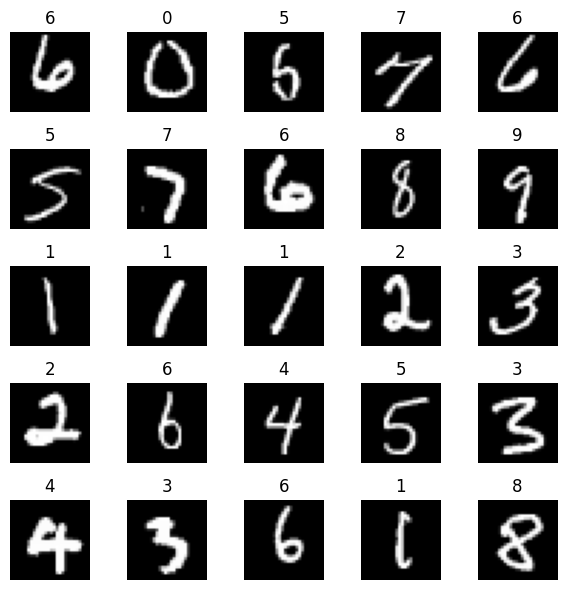

torch.Size([64, 1, 28, 28])
tensor([6, 0, 5, 7, 6, 5, 7, 6, 8, 9])


In [4]:
"""
Visualize dataset
"""
# Get one batch of images and labels
images, labels = next(iter(train_loader))

# Plot the first 25 images in a 5x5 grid
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')  # squeeze removes the channel dim
    plt.title(f"{labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print(images.shape)  # torch.Size([64, 1, 28, 28])
print(labels[:10])   # tensor of labels

In [5]:
# Train on GPU if possible
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else 
                      "cpu")

# Define the model
model = Models.SmallConvNet().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [6]:
"""
Train the basic model (no adversarial training)
"""
Defences.train_vanilla(model, train_loader, test_loader, optimizer, criterion, device, num_epochs=6, test_eval_rate=2)

Epoch 1/6 | Train Loss: 0.3887, Train Acc: 88.10%
Epoch 2/6 | Train Loss: 0.0995, Train Acc: 97.02% | Test Loss: 0.0719, Test Acc: 97.77%
Epoch 3/6 | Train Loss: 0.0702, Train Acc: 97.83%
Epoch 4/6 | Train Loss: 0.0576, Train Acc: 98.22% | Test Loss: 0.0491, Test Acc: 98.32%
Epoch 5/6 | Train Loss: 0.0469, Train Acc: 98.54%
Epoch 6/6 | Train Loss: 0.0417, Train Acc: 98.71% | Test Loss: 0.0483, Test Acc: 98.43%


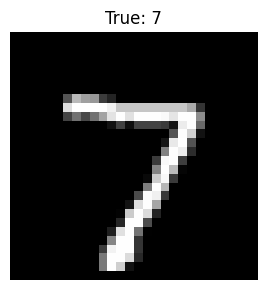

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 0.00 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 1.00 | 8: 0.00 | 9: 0.00


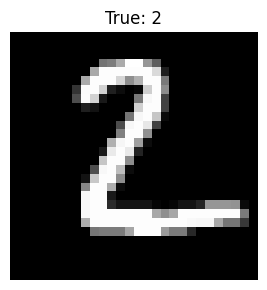

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 1.00 | 3: 0.00 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


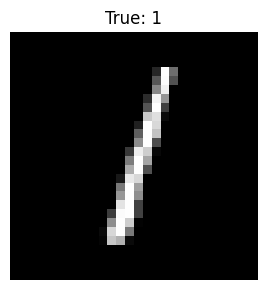

Output probabilities: 0: 0.00 | 1: 1.00 | 2: 0.00 | 3: 0.00 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


In [7]:
images, labels = next(iter(test_loader))
Tools.plot_predictions(model, images, labels, device, 3)

Fun note / something to explore: how the perturbation shapes very with respect to model size/epsilon/k/...

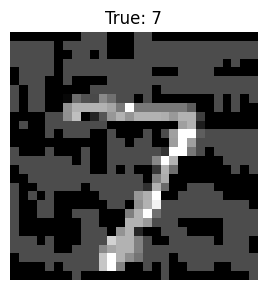

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 0.99 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


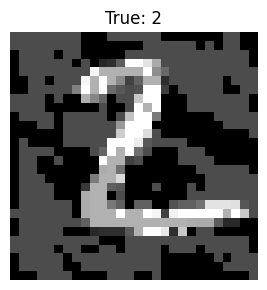

Output probabilities: 0: 0.00 | 1: 0.04 | 2: 0.00 | 3: 0.95 | 4: 0.00 | 5: 0.01 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


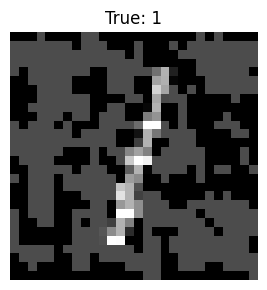

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.03 | 3: 0.52 | 4: 0.02 | 5: 0.01 | 6: 0.00 | 7: 0.00 | 8: 0.42 | 9: 0.00


In [8]:
"""
Plot a few attacks with k = 1 (one iteration, FGSM attack)
The model is completely fooled by those with epsilon = 0.3.
Note that we use a much higher epsilon (perturbation value) than in the typical imagenet example (usually around 0.01
is enough to mess up the predictions). This is because MNIST has much smaller dimensions, number of classes and all around complexity !
"""

epsilon = 0.3

images, labels = next(iter(test_loader))

# Generate 3 adversarial images and plot predictions
image = images[:3, :, :]
label = labels[:3]
adv_image, perturbation = Attacks.fgsm_attack(image, label, model, nn.CrossEntropyLoss(), epsilon, device)

Tools.plot_predictions(model, adv_image, label, device, 3)

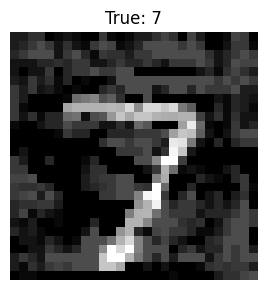

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 1.00 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


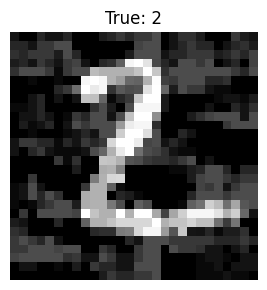

Output probabilities: 0: 0.00 | 1: 0.72 | 2: 0.00 | 3: 0.28 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


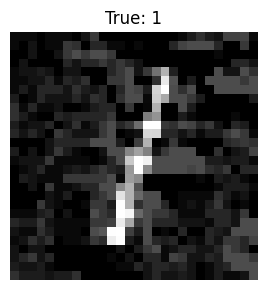

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 0.00 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 1.00 | 9: 0.00


In [9]:
"""
Now a few attacks with PGD attacks (k = 8 iterations, still epsilon = 0.2).
We notice that the model is now fooled with maximum confidence !
Again, it's fun to note that the perturbation shapes have changed
"""

adv_image, perturbation = Attacks.pgd_attack(image, label, model, nn.CrossEntropyLoss(), epsilon, 8, device)
Tools.plot_predictions(model, adv_image, label, device, 3)

In [10]:
"""
this first robustModel is trained on adversarial examples with the linear mix scheduler advocated by the CAT paper.
Higher accuracy on test set since train set has adversarial examples.
"""

robust_model = Models.SmallConvNet().to(device)
robust_optimizer = torch.optim.Adam(robust_model.parameters(), lr=1e-3)
robust_criterion = nn.CrossEntropyLoss()

linmix_scheduler = Schedulers.LinearUniformMixScheduler(k_min=0, k_max=5)

Defences.train_with_adversarial_scheduler(robust_model, train_loader, test_loader, robust_optimizer, robust_criterion, epsilon, linmix_scheduler, device, num_epochs=6, test_eval_rate=2)

Epoch 1/6 | Train Loss: 0.3448, Train Acc: 89.35%
Epoch 2/6 | Train Loss: 0.6097, Train Acc: 80.18% | Test Loss: 0.0817, Test Acc: 97.32%
Epoch 3/6 | Train Loss: 0.9120, Train Acc: 69.16%
Epoch 4/6 | Train Loss: 0.7592, Train Acc: 73.99% | Test Loss: 0.0759, Test Acc: 97.57%
Epoch 5/6 | Train Loss: 0.7140, Train Acc: 75.55%
Epoch 6/6 | Train Loss: 0.5979, Train Acc: 80.03% | Test Loss: 0.0871, Test Acc: 97.39%


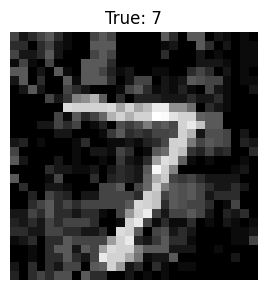

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 0.01 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.98 | 8: 0.00 | 9: 0.01


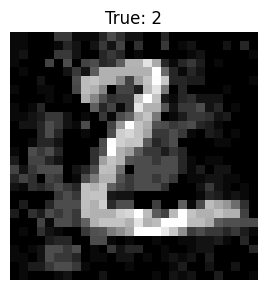

Output probabilities: 0: 0.01 | 1: 0.04 | 2: 0.88 | 3: 0.05 | 4: 0.00 | 5: 0.00 | 6: 0.02 | 7: 0.00 | 8: 0.00 | 9: 0.00


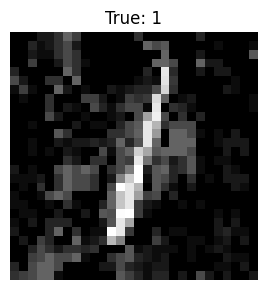

Output probabilities: 0: 0.00 | 1: 0.93 | 2: 0.01 | 3: 0.00 | 4: 0.01 | 5: 0.00 | 6: 0.01 | 7: 0.03 | 8: 0.01 | 9: 0.00


In [11]:
"""
Unlike the basic model, the robust model is not fooled by those adversarial examples, although the confidence is affected.
Notice that we trained it with k = 5 at most, but its robustness holds with k = 8
"""

adv_image, perturbation = Attacks.pgd_attack(image, label, robust_model, nn.CrossEntropyLoss(), epsilon, 8, device)
Tools.plot_predictions(robust_model, adv_image, label, device, 3)

In [12]:
"""
Let's compare our robustModel trained with the linear mix scheduler with a model trained with the
more naive approach of using constant k during training.
"""

naive_model = Models.SmallConvNet().to(device)
naive_optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3)
naive_criterion = nn.CrossEntropyLoss()

constant_scheduler = Schedulers.ConstantScheduler(k_min=5, k_max=5)

Defences.train_with_adversarial_scheduler(naive_model, train_loader, test_loader, naive_optimizer, naive_criterion, epsilon, constant_scheduler, device, num_epochs=6, test_eval_rate=2)

Epoch 1/6 | Train Loss: 1.8741, Train Acc: 30.67%
Epoch 2/6 | Train Loss: 1.3257, Train Acc: 47.95% | Test Loss: 0.4952, Test Acc: 88.96%
Epoch 3/6 | Train Loss: 1.0804, Train Acc: 57.83%
Epoch 4/6 | Train Loss: 0.8698, Train Acc: 67.39% | Test Loss: 0.2679, Test Acc: 93.79%
Epoch 5/6 | Train Loss: 0.7204, Train Acc: 74.09%
Epoch 6/6 | Train Loss: 0.6600, Train Acc: 76.91% | Test Loss: 0.2073, Test Acc: 94.62%


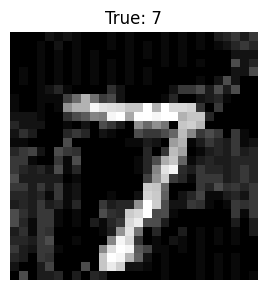

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.00 | 3: 0.00 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.99 | 8: 0.00 | 9: 0.00


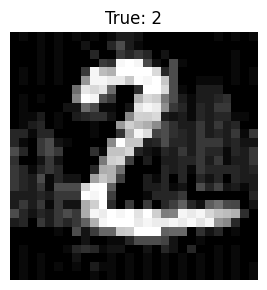

Output probabilities: 0: 0.00 | 1: 0.00 | 2: 0.98 | 3: 0.02 | 4: 0.00 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


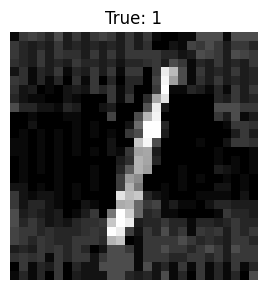

Output probabilities: 0: 0.00 | 1: 0.97 | 2: 0.00 | 3: 0.00 | 4: 0.02 | 5: 0.00 | 6: 0.00 | 7: 0.00 | 8: 0.00 | 9: 0.00


In [13]:
"""
The test accuracy is worst than the robust model (97.8 vs 94.1)
It might be a bit more confident on adversarial images but we need a bigger sample size to make sure.
Importantly, training took 1min2sec vs. 37 seconds for the linear mix scheduler.
"""

adv_image, perturbation = Attacks.pgd_attack(image, label, naive_model, nn.CrossEntropyLoss(), epsilon, 8, device)
Tools.plot_predictions(naive_model, adv_image, label, device, 3)

In [14]:
torch.save(model.state_dict(), "../models/small_conv_vanilla.pth")
torch.save(robust_model.state_dict(), "../models/small_conv_adversarial_linear_mix_scheduler_k_0_to_5.pth")
torch.save(naive_model.state_dict(), "../models/small_conv_constant_scheduler_k_5.pth")